# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [25]:
# Load pickled data
import pickle
import os

# Get the training, validation and test data
training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, sizes_train, coords_train = train['features'], train['labels'], train['sizes'], train['coords']
X_valid, y_valid, sizes_valid, coords_valid = valid['features'], valid['labels'], valid['sizes'], valid['coords']
X_test, y_test, sizes_test, coords_test = test['features'], test['labels'], test['sizes'], test['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [26]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = str(X_test.shape[1]) + ' x ' + str(X_test.shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = 32 x 32
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

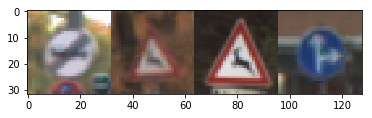

In [27]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def sample_images(source):
    return np.concatenate((source[100], source[300], source[500], source[900]), axis=1)

# Display the sample images
plt.imshow(sample_images(X_train))


### Extending the dataset by cloning the training data using translation and rotation operation

In [28]:
import cv2
import math
from tqdm import *

def translate_image(img, tx, ty):
    num_rows, num_cols = img.shape[:2]
    translation_matrix = np.float32([ [1,0,tx], [0,1,ty] ])
    
    return cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))

def rotate_about_center(src, angle, scale=1.):
    w = src.shape[1]
    h = src.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = w
    nh = h
    # ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw*0.5, nh*0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw-w)*0.5, (nh-h)*0.5,0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0,2] += rot_move[0]
    rot_mat[1,2] += rot_move[1]
    
    return cv2.warpAffine(src, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)

def clone_by_rotation(img):
    DEG = 20
    clones = []
                    
    # Do a rotation operations 
    clones.append(rotate_about_center(img, DEG))        
    clones.append(rotate_about_center(img, DEG * -1))
        
    return clones

def clone_image(img, sizes, coords):
    # Start cloning through rotation in same position
    clones = clone_by_rotation(img)
            
    # Clone by translational combinations    
    img_size = sizes
    img_coords = coords

    width = img_size[0]
    height = img_size[1]

    x1 = img_coords[0]
    y1 = img_coords[1]
    x2 = img_coords[2]
    y2 = img_coords[3]
    
    # Translations
    top = y1 * -1
    bottom = height - y2
    right = width - x2
    left = x1 * -1

    # Right + Bottom
    cln = translate_image(img, right, bottom)
    clones.append(cln)        
    clones += clone_by_rotation(cln)
            
    # Right + Top
    cln = translate_image(img, right, top)
    clones.append(cln)
    clones += clone_by_rotation(cln)
    
    # Left + Top
    cln = translate_image(img, left, top)
    clones.append(cln)
    clones += clone_by_rotation(cln)
    
    # Left + Bottom
    cln = translate_image(img, left, bottom)
    clones.append(cln)
    clones += clone_by_rotation(cln)

    return clones

def clone_dataset(images, sizes, coords):
    clones = []
    
    for idx in tqdm(range(len(images))):
        clones += clone_image(images[idx], sizes[idx], coords[idx])
        
    return clones


In [29]:
def get_extra_training_data(original_data, sizes, coords):
    path = 'dataset/extra.p'
    
    if os.path.exists(path):
        extra_data = pickle.load(open(path, 'rb'))
    else:
        # Generate
        extra_data = clone_dataset(original_data, sizes, coords)
        # Preserve
        pickle.dump(extra_data, open(path, 'wb'))
        
    return extra_data

def get_extra_training_labels(original_labels, count):
    y_train_extra = []
    
    # Clone the labels
    for idx in tqdm(range(len(original_labels))):
        y = original_labels[idx]
        extra = np.full((count), y, dtype=int)
        y_train_extra += extra.tolist()
        
    return y_train_extra
    
print('Generating new training data...')
    
# Image gets cloned 14 times through different position and orientations
# So total is 14(clones) + 1(original) = 15
clones = get_extra_training_data(X_train, sizes_train, coords_train)
clones = np.array(clones)
# Concatenate the original dataset with this extra training data
X_train_extra = np.concatenate((X_train, clones), axis=0)

# Clone the labels
y_train_extra = get_extra_training_labels(y_train, 15)
y_train_extra = np.array(y_train_extra)

print('Generated {} extra training data'.format(len(clones)))

assert(len(X_train_extra) == len(y_train_extra)), 'Number of inputs and labels are not matching'


Generating new training data...


100%|██████████████████████████████████████████████████████| 34799/34799 [00:00<00:00, 55875.09it/s]


Generated 487186 extra training data


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [30]:
import warnings
from skimage import exposure

def minimax(x, min=0, max=255):
    return (x - min) / (max - min)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def normalize_exposure(x):    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for idx in tqdm(range(len(x))):
            x[idx] = exposure.equalize_adapthist(x[idx])
        
        return x

def reshape_inputs(x_data):
    shape = list(x_data.shape)
    return np.reshape(x_data, shape + [1])


In [8]:
PATH = 'dataset/processed/{}.p'

def preprocess(inp, path=None):
    print('Starting Preprocessing')
    if path != None and os.path.exists(path):
        print('Loading from {}'.format(path))
        inp_proc = pickle.load(open(path, 'rb'))
    else:
        # Normalize using minimax
        inp_proc = minimax(inp)

        # Convert to grayscale
        inp_proc = rgb2gray(inp_proc)

        # Normalize exposure
        inp_proc = normalize_exposure(inp_proc)        

        # Persist the processed data if needed
        if path != None:
            pickle.dump(inp_proc, open(path, 'wb'))
    
    return inp_proc

# Do the preprocessing
train_input = preprocess(X_train_extra, PATH.format('train'))
valid_input = preprocess(X_valid, PATH.format('valid'))
test_input = preprocess(X_test, PATH.format('test'))




Starting Preprocessing
Loading from dataset/processed/train.p
Starting Preprocessing
Loading from dataset/processed/valid.p
Starting Preprocessing
Loading from dataset/processed/test.p


In [33]:
print(train_input.shape)

# Display the sample images after pre-processing
# plt.imshow(sample_images(train_input), cmap = plt.get_cmap('gray'))
# plt.show()

# # Reshape the inputs
# train_input = reshape_inputs(train_input)
# valid_input = reshape_inputs(valid_input)
# test_input = reshape_inputs(test_input)




(521985, 32, 32, 1)


TypeError: Invalid dimensions for image data

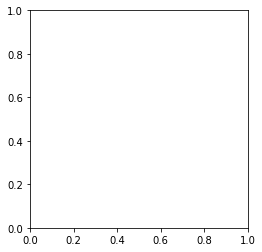

In [34]:
plt.imshow(train_input[55557], cmap = plt.get_cmap('gray'))

### Model Architecture

In [35]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

class HyperParameters:
    def __init__(self, epochs, batch_size, learning_rate, keep_prob):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob

def weights_init(shape):
    mu = 0
    sigma = 0.1
    
    return tf.Variable(tf.truncated_normal(shape, mu, sigma))

def bias_init(num):
    return tf.Variable(tf.zeros(num))

# Creates a convolutional layer
def convolve(x, filter_shape, no_of_filters):
    # Define the shape of the weights (Filter dimension * Number of filters)        
    weights = weights_init(filter_shape + [no_of_filters])
    bias = bias_init(no_of_filters)
    
    # Construct the layer
    layer = tf.nn.conv2d(x, weights, [1, 1, 1, 1], 'VALID') + bias
    
    # Do the activation and return 
    return tf.nn.relu(layer)
                      
def max_pool(x):
    return tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

def fully_connect(x, no_of_neurons, with_activation=True):
    shape = x.get_shape().as_list()
    del shape[0]
    weights = weights_init(shape + [no_of_neurons])
    bias = bias_init(no_of_neurons)
    
    layer = tf.matmul(x, weights) + bias
    
    # If activation is required
    if with_activation:
        layer = tf.nn.relu(layer)
    
    return layer


def network(x, y, keep_prob, no_of_classes):
    # Layer 1: Convolutional
    out = convolve(x, [5, 5, 1], 6)
    
    # Layer 2: Max-Pooling
    out = max_pool(out)
    
    # Layer 3: Convolutional
    out = convolve(out, [5, 5, 6], 16)
    
    # Layer 4: Max-Pooling
    out = max_pool(out)
    
    # Flatten
    out = flatten(out)
    
    # Layer 5: Fully connected
    out = fully_connect(out, 120)
    
    # Add a dropout
    out = tf.nn.dropout(out, keep_prob)
    
    # Layer 6: Fully connected
    out = fully_connect(out, 84)
    
    # Add a dropout
    out = tf.nn.dropout(out, keep_prob)
    
    # Layer 7: Fully connected (Without activation)
    logits = fully_connect(out, no_of_classes, False)
    
    # Optimizers    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate)
    training_graph = optimizer.minimize(loss)
    
    # For accuracy
    prediction_graph = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    
    return logits, training_graph, prediction_graph

def validate(x_data, y_data, logits, prediction_graph, batch_size):
    num_examples = len(x_data)
    total_accuracy = 0
    
    accuracy_graph = tf.reduce_mean(tf.cast(prediction_graph, tf.float32))
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = offset + params.batch_size
        batch_x, batch_y = x_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_graph, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples
    

def train(x_data, y_data, training_graph, logits, prediction_graph, params, x_valid, y_valid):
    # To save the model at the end of training session
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        # Initializing all the variables
        sess.run(tf.global_variables_initializer())
        num_examples = len(x_data)
        
        print('Training...')
        print()
        
        # For each epoch
        for idx in tqdm(range(params.epochs)):
            # some randomness in data
            x_data, y_data = shuffle(x_data, y_data)
            
            for offset in range(0, num_examples, params.batch_size):
                end = offset + params.batch_size
                batch_x, batch_y = x_data[offset:end], y_data[offset:end]
                                                
                # Start the run
                sess.run(training_graph, feed_dict={x:batch_x, y:batch_y, keep_prob: params.keep_prob})
            
            accuracy = validate(x_valid, y_valid, logits, prediction_graph, params.batch_size)
            print('EPOCH {} ...'.format(idx + 1))
            print('Accuracy = {:.3f}'.format(accuracy))
            print()
            
        saver.save(sess, './traffic_sign.ckpt')
        print('Model saved')
            
    
def test(x_data, y_data, logits, prediction_graph, batch_size):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        
        saver.restore(sess, './traffic_sign.ckpt')
        
        accuracy = validate(x_data, y_data, logits, prediction_graph, batch_size)
        print('Test Accuracy = {:.3f}'.format(accuracy))
        
        return accuracy

def get_predictions(x_data, y_data, logits, top=5):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        
        saver.restore(sess, './traffic_sign.ckpt')
        
        return sess.run(tf.nn.top_k(logits, k=top), feed_dict={x: x_data, y: y_data, keep_prob: 1.0})

    

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [36]:
# Initialize Hyperparameters
params = HyperParameters(epochs=10, batch_size=512, learning_rate=0.0001, keep_prob=0.6)

# Prepare the features and labels
input_shape = list(train_input.shape)
input_shape[0] = None

keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, input_shape)
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Build the network training graph
logits, training_graph, prediction_graph = network(x, one_hot_y, keep_prob, n_classes)


### Training the model

In [37]:
# Do training
train(train_input, y_train_extra, training_graph, logits, prediction_graph, params, valid_input, y_valid)

Training...



  0%|                                                                        | 0/10 [00:00<?, ?it/s]

EPOCH 1 ...
Accuracy = 0.095



 10%|██████▎                                                        | 1/10 [01:51<16:43, 111.55s/it]

EPOCH 2 ...
Accuracy = 0.080



 20%|████████████▌                                                  | 2/10 [03:51<15:12, 114.06s/it]

EPOCH 3 ...
Accuracy = 0.057



 30%|██████████████████▉                                            | 3/10 [05:25<12:37, 108.15s/it]

EPOCH 4 ...
Accuracy = 0.040



 40%|█████████████████████████▏                                     | 4/10 [06:54<10:13, 102.26s/it]

KeyboardInterrupt: 

### Testing the model

In [ ]:
test(test_input, y_test, logits, prediction_graph, params.batch_size)


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
from matplotlib.image import imread
from matplotlib.pyplot import figure, imshow, axis

# The images are named as their labels
labels = [3, 14, 17, 22, 25]

WEB_IMAGE_PATH = 'examples/web/{}.jpg'

# Container to store the images
web_images = []
     
def load_and_output_web_images(path, labels):
    fig = figure()

    idx = 1
    for lbl in labels:
        fig.add_subplot(1, len(labels), idx)
        image = imread(path.format(lbl))
        web_images.append(image)
        imshow(image)
        axis('off')    
        idx += 1

# Display the images from web
load_and_output_web_images(WEB_IMAGE_PATH, labels)


### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

inp = np.array(web_images)

# Do Preprocessing
inp = preprocess(inp)

# Do reshape
inp = reshape_inputs(inp)

# Run through the prediction
accuracy = test(inp, labels, logits, prediction_graph, len(labels))

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print('Accuracy for these images is {:.0f}%'.format(accuracy * 100))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

#### Readable names from CSV

In [ ]:
import re

# Read the csv file to get the readable names for the labels
labels_texts = np.genfromtxt('signnames.csv', dtype=None, delimiter=',', names=True) 

def get_labels_text(index):
    _, text = labels_text[index]
    
    # Convert to string
    text = str(text)
    
    # Do the cleanup
    return re.search("'.*'", text).group(0).replace("'", '')

#### Predictions

In [ ]:
# Get the top 5 predicted labels for the web images
labels, indices = get_predictions(inp, labels, logits)

#### Visualization

In [ ]:
def visualize_prediction(x_axis, y_axis, image):
    y_pos = np.arange(len(y_axis))
    
    # Plot the predictions
    plt.subplot(1, 2, 1)
    plt.barh(y_pos, x_axis, align='edge', alpha=0.5, color='r')
    plt.yticks(y_pos, y_axis)
    plt.xlabel('Predictions')    
    plt.xticks([])
    
    # Plot the image
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.axis('off')
    
    plt.show()

    
# Loop through all the predictions and display the visualization
for idx in range(len(labels)):
    x_axis = labels[idx]
    index = indices[idx]
    
    # Translate the index value to a readable text using csv reference
    y_axis = []    
    for idx_val in index:
        text = get_labels_text(idx_val)
        y_axis.append(text)
        
                
    visualize_prediction(x_axis, y_axis, web_images[idx])
        
        

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")